<a href="https://colab.research.google.com/github/ZackAkil/stateful-object-tracking/blob/main/notebooks/Object_tracking_class_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/ZackAkil/stateful-object-tracking/raw/main/trained_models/400_700_v2_68.h5

In [ ]:
!wget https://github.com/ZackAkil/stateful-object-tracking/raw/main/training_data/drone_45.mp4

In [ ]:
!wget https://raw.githubusercontent.com/ZackAkil/stateful-object-tracking/main/utils/utils.py

In [2]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/400_700_v2_68.h5')

In [5]:
from IPython.display import HTML

# Provide the path to the video file
video_path = 'https://github.com/ZackAkil/stateful-object-tracking/raw/main/training_data/drone_45.mp4'

# Generate the HTML code to embed the video
video_html = f"""
<video controls autoplay>
    <source src="{video_path}" type="video/mp4">
</video>
"""

# Display the video in Colab
HTML(video_html)

In [7]:
import cv2

# Open the video file
video_path = '/content/drone_45.mp4'
video = cv2.VideoCapture(video_path)

In [8]:
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames

1136

In [23]:
import numpy as np

In [58]:
WIDTH = 700
HEIGHT = 400
n = 60

X = np.zeros((n, HEIGHT, WIDTH, 3))

In [68]:
for i in range(n):
  ret, frame = video.read()
  frame = cv2.resize(frame, (700, 400))
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
  X[i,:,:,:] = frame/255.

In [69]:
import matplotlib.pyplot as plt

In [70]:
X[10].shape

(400, 700, 3)

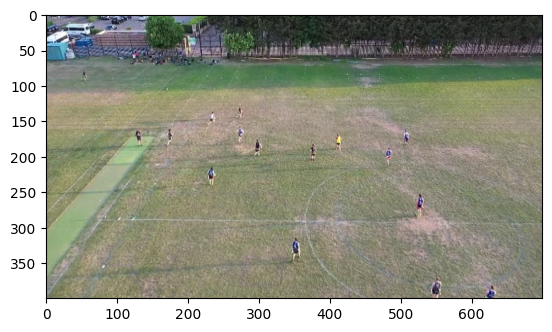

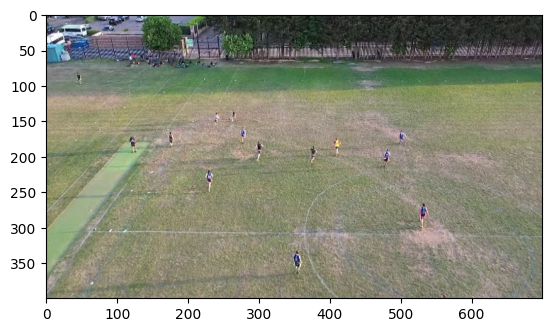

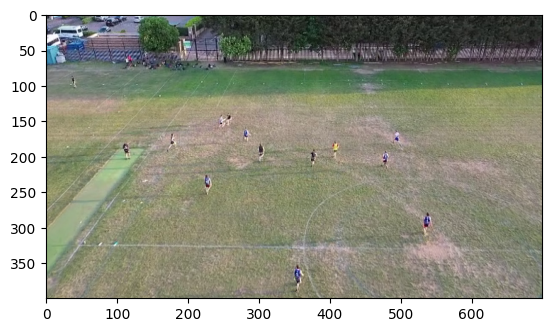

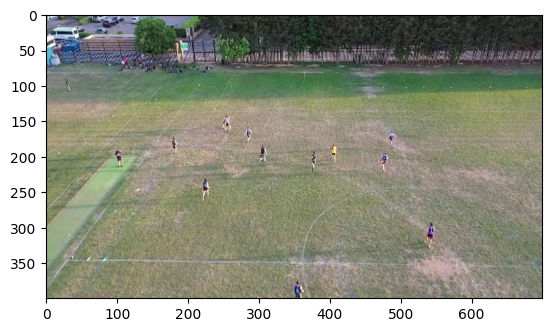

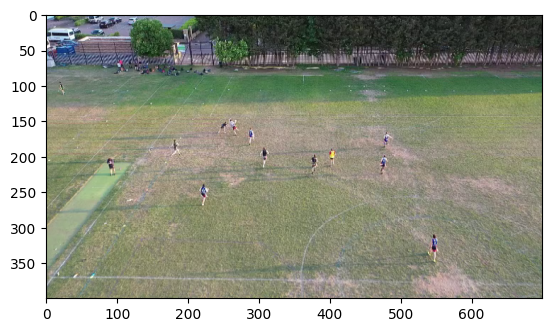

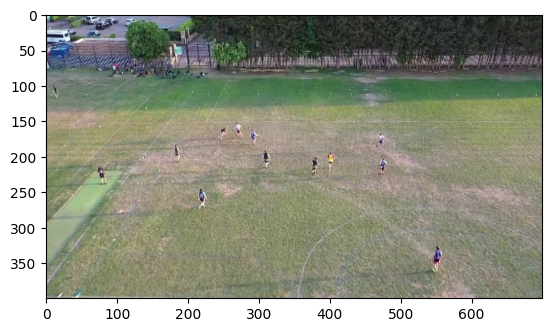

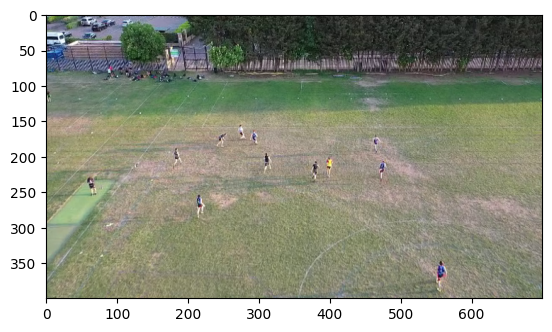

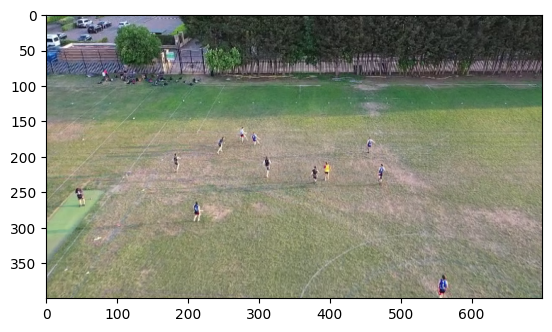

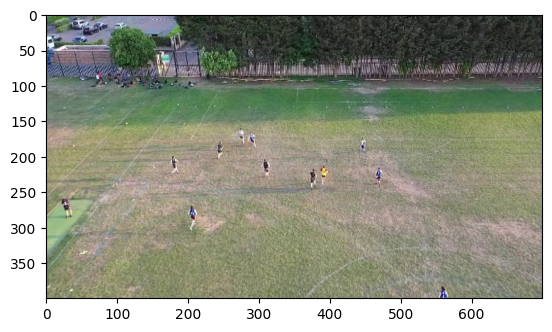

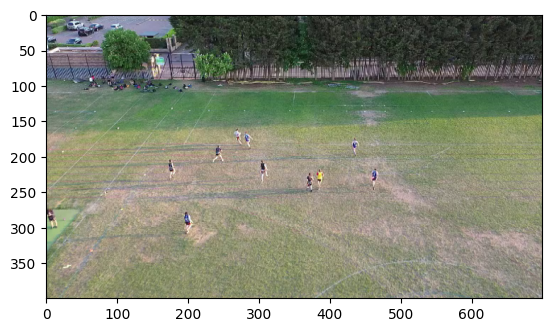

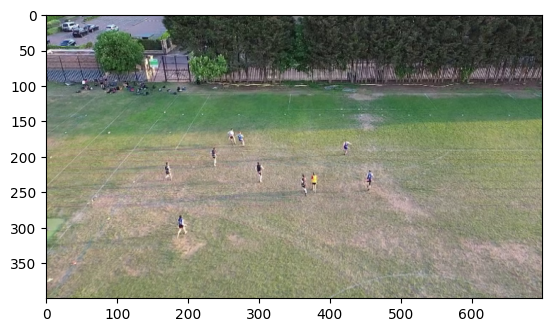

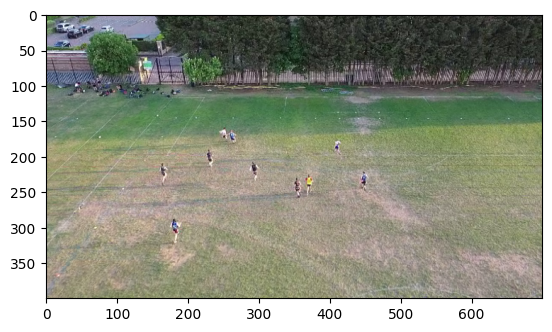

In [74]:
for i in range(0,n,5):
  plt.imshow(X[i])
  plt.show()

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 400, 700, 32)      896       
                                                                 
 conv2d_15 (Conv2D)          (None, 400, 700, 32)      9248      
                                                                 
 conv2d_16 (Conv2D)          (None, 400, 700, 32)      9248      
                                                                 
 conv2d_17 (Conv2D)          (None, 400, 700, 32)      9248      
                                                                 
 conv2d_18 (Conv2D)          (None, 400, 700, 32)      9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 400, 700, 32)      9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 400, 700, 1)      

In [75]:
prediction = model.predict(X)

2/2 [==============================] - 51s 24s/step


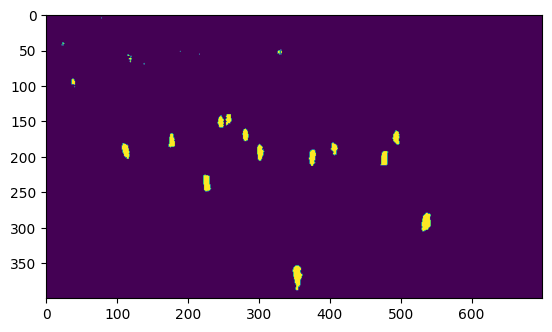

In [77]:
plt.imshow(prediction[10]>0.9)

In [86]:
import importlib

In [84]:
import utils

In [179]:
importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [180]:
raw_boxes = []

for pred in prediction:
  boxes = utils.run_box_huristic(pred, 0.9)
  raw_boxes.append(boxes)

In [181]:
len(raw_boxes)

60

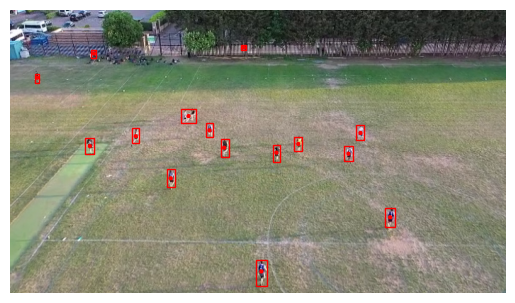

In [182]:
utils.plot_boxes(X[10], raw_boxes[10])

# Create path based on boxes

In [183]:
# given a collection of bboxes using the mid-points

In [184]:
xs = []
ys = []
frame_counts = []

for frame in raw_boxes:
  frame_counts.append(len(frame))
  for box in frame:
    x = box['pos']['x']
    y = box['pos']['y']
    xs.append(x)
    ys.append(y)

In [185]:
# make pretty colours
numbers = frame_counts
indexed_list = [idx for idx, num in enumerate(numbers) for _ in range(num)]

# Plot all mid points over the course of all frames

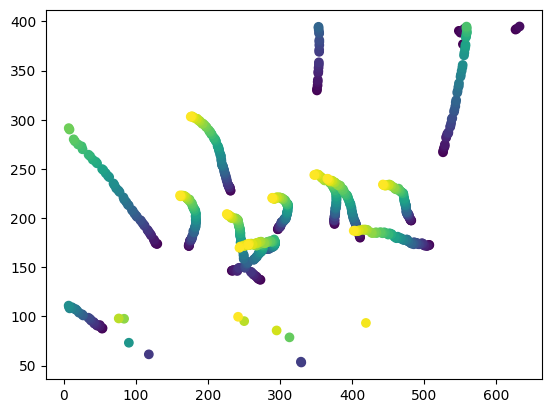

In [186]:
plt.scatter(xs, ys, c=indexed_list)

In [189]:
import math

class Stateful_Object:

  def __init__(self):
    self.name = ""
    self.frames = []
    self.active = True
    self.grace_periode = 30
    self.closeness_threshold = 30

  def __str__(self):
    return f"Stateful Object with {len(self.frames)} frames."

  def __dict__(self):
        return {'frames':self.frames}

  def previous_position(self):
    return self.frames[-1]

  def closeness(self, bbox):
    x1 = bbox['pos']['x']
    y1 = bbox['pos']['y']

    prev_bbox  = self.previous_position()
    x2 = prev_bbox['pos']['x']
    y2 = prev_bbox['pos']['y']

    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    return distance

  def is_same_object(self, bbox):
    return self.closeness(bbox) < self.closeness_threshold

  def add_bbox(self, bbox, time_stamp):
    return self.frames.append({**bbox, "time_stamp": time_stamp})


class Stateful_Object_Tracker:

  def __init__(self):
    self.stateful_objects = []

  def __dict__(self):
    return {'object_tracks': [s_o.__dict__() for s_o in self.stateful_objects]}
        # return self.stateful_objects

  def __json__(self):
    return {'object_tracks': [s_o.__dict__() for s_o in self.stateful_objects]}

  def analyse_frames(self, frames):
    for i, frame in enumerate(frames):
      self.analyse_frame(frame, i)


  def analyse_frame(self, frame, time_stamp):

    for bbox in frame:

      closest_object = self.find_closest_object(bbox)

      if closest_object:
        closest_object.add_bbox(bbox, time_stamp)
      else:
        new_s_object = Stateful_Object()
        new_s_object.add_bbox(bbox, time_stamp)
        self.stateful_objects.append(new_s_object)


  def find_closest_object(self, bbox):
    # return the closest valid match
    if self.stateful_objects == []:
      return None

    ranked_objects = sorted(self.stateful_objects,
                            key=lambda obj: obj.closeness(bbox))

    if ranked_objects[0].is_same_object(bbox):
      return ranked_objects[0]

    return None

  def plot_tracks(self):

    for s_o in self.stateful_objects:
      frames = s_o.frames
      x = [p['pos']['x'] for p in frames]
      y = [p['pos']['y'] for p in frames]
      plt.plot(x, y)
    plt.show()

In [190]:

tracker = Stateful_Object_Tracker()
tracker.analyse_frames(raw_boxes)


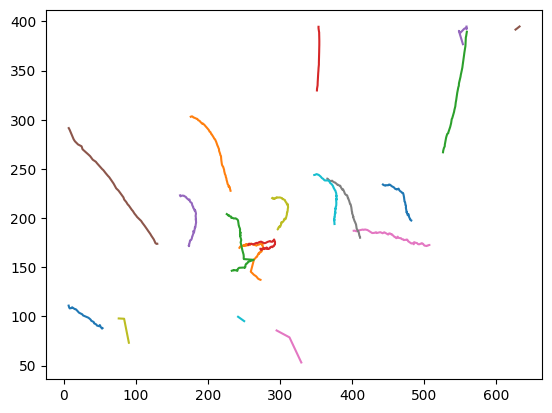

In [191]:
tracker.plot_tracks()

In [192]:
print(tracker.stateful_objects[0])

Stateful Object with 25 frames.


In [193]:
import json

In [199]:
json_data = json.dumps(tracker.__json__(), indent=4)
with open("tracking.json", "w") as file:
    file.write(json_data)